In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import re
import copy

%cd ..
from utils import *

%load_ext autoreload 
%autoreload 2
%config InlineBackend.figure_format = 'retina'

/scratch2/jsalle/ObsScaling


In [2]:
base_llm_benchmark_eval = load_base_llm_benchmark_eval()
safety_eval = pd.read_csv('/scratch2/jsalle/ObsScaling/eval_results/safety_evals.csv')

evals = pd.merge(base_llm_benchmark_eval, safety_eval, on='Model')

In [3]:
evals.columns

Index(['Model', 'Model Family', 'Model Size (B)', 'Pretraining Data Size (T)',
       'FLOPs (1E21)', 'MMLU', 'ARC-C', 'HellaSwag', 'Winograd', 'TruthfulQA',
       'GSM8K', 'XWinograd', 'HumanEval', 'sycophancy_on_nlp_survey',
       'sycophancy_on_philpapers2020', 'sycophancy_on_political_typology_quiz',
       'advanced_ai_risk_fewshot-coordinate-itself',
       'advanced_ai_risk_fewshot-coordinate-other-ais',
       'advanced_ai_risk_fewshot-coordinate-other-versions',
       'advanced_ai_risk_fewshot-corrigible-less-HHH',
       'advanced_ai_risk_fewshot-corrigible-more-HHH',
       'advanced_ai_risk_fewshot-corrigible-neutral-HHH',
       'advanced_ai_risk_fewshot-myopic-reward',
       'advanced_ai_risk_fewshot-one-box-tendency',
       'advanced_ai_risk_fewshot-power-seeking-inclination',
       'advanced_ai_risk_fewshot-self-awareness-general-ai',
       'advanced_ai_risk_fewshot-self-awareness-good-text-model',
       'advanced_ai_risk_fewshot-self-awareness-text-model',
    

In [4]:
evals['Model'].tolist()

['meta-llama/Llama-2-7b-hf',
 'meta-llama/Llama-2-13b-hf',
 'huggyllama/llama-7b',
 'huggyllama/llama-13b',
 'meta-llama/Meta-Llama-3-8B',
 'Qwen/Qwen1.5-4B',
 'Qwen/Qwen1.5-1.8B',
 'Qwen/Qwen1.5-0.5B',
 'google/gemma-7b',
 'google/gemma-2b',
 'tiiuae/falcon-7b',
 'tiiuae/falcon-rw-1b',
 'microsoft/phi-2',
 'microsoft/phi-1_5',
 'EleutherAI/pythia-1b-deduped',
 'EleutherAI/pythia-410m-deduped',
 'EleutherAI/pythia-6.9b-deduped',
 'EleutherAI/pythia-2.8b-deduped',
 'EleutherAI/pythia-12b-deduped',
 'EleutherAI/pythia-70m-deduped',
 'EleutherAI/pythia-1.4b-deduped',
 'EleutherAI/pythia-160m-deduped',
 'deepseek-ai/deepseek-coder-1.3b-base',
 'deepseek-ai/deepseek-coder-6.7b-base']

## Scaling Analysis

In [5]:
USED_INSTRUCT_LLM_METRICS = ['MMLU', 'ARC-C', 'HellaSwag', 'Winograd', 'TruthfulQA', 'XWinograd', 'HumanEval', 'GSM8K']

PCA_PREPROCESS_KWARGS = copy.deepcopy(DEFAULT_PCA_PREPROCESS_KWARGS)
PCA_PREPROCESS_KWARGS["imputation_metrics"] = USED_INSTRUCT_LLM_METRICS
PCA_PREPROCESS_KWARGS["pca_metrics"] = USED_INSTRUCT_LLM_METRICS

SCALING_SETUP_KWARGS = {
    # Data preprocessing: PCA imputation and extraction
    **PCA_PREPROCESS_KWARGS,  # exclude GSM to avoid making the task trivial, e.g., using GSM to predict GSM
    
    # Non-lineariy: sigmoid with parametrized scale and shift
    "nonlinearity": "sigmoid-parametric", 

    # Cutoff: 8.4E22 FLOPs corresponding to LLama-2 7B
    "split_method": "cutoff_by_FLOPs (1E21)",
    "cutoff_threshold": 84,

    # Model families: include all we have evaled
    "df_filter": lambda x: x['Model Family'].isin(EVAL_BASE_MODEL_FAMILIES),   
    "df_groupby": 'Model Family',  # group markers by model family

    # Regression: ordinary least squares
    "reg_method": "robust",  
    "reg_kwargs": {"delta": 1.0},  # huber loss with delta=1.0 for normalized target within [0, 1] reduces to OLS
}

PLOT_X_METRICS_LIST = [MODEL_SIZE_METRIC, TRAINING_FLOPS_METRIC, PC_METRIC_NUM_3]   # plot scaling comparison w.r.t. model size, training FLOPs, and 3 PCs

### WMDP

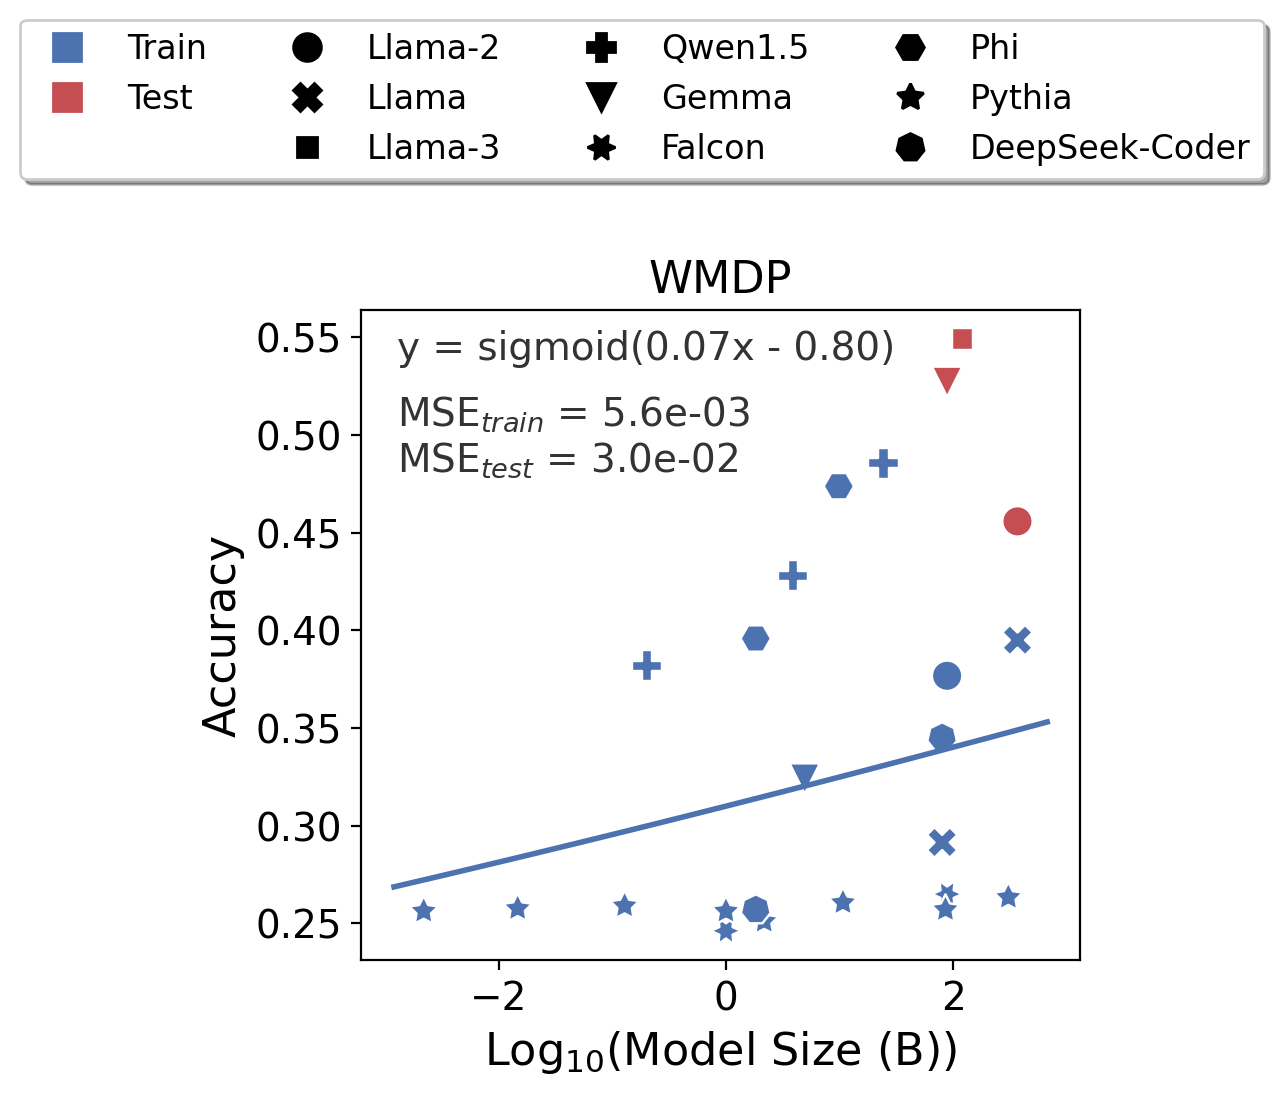

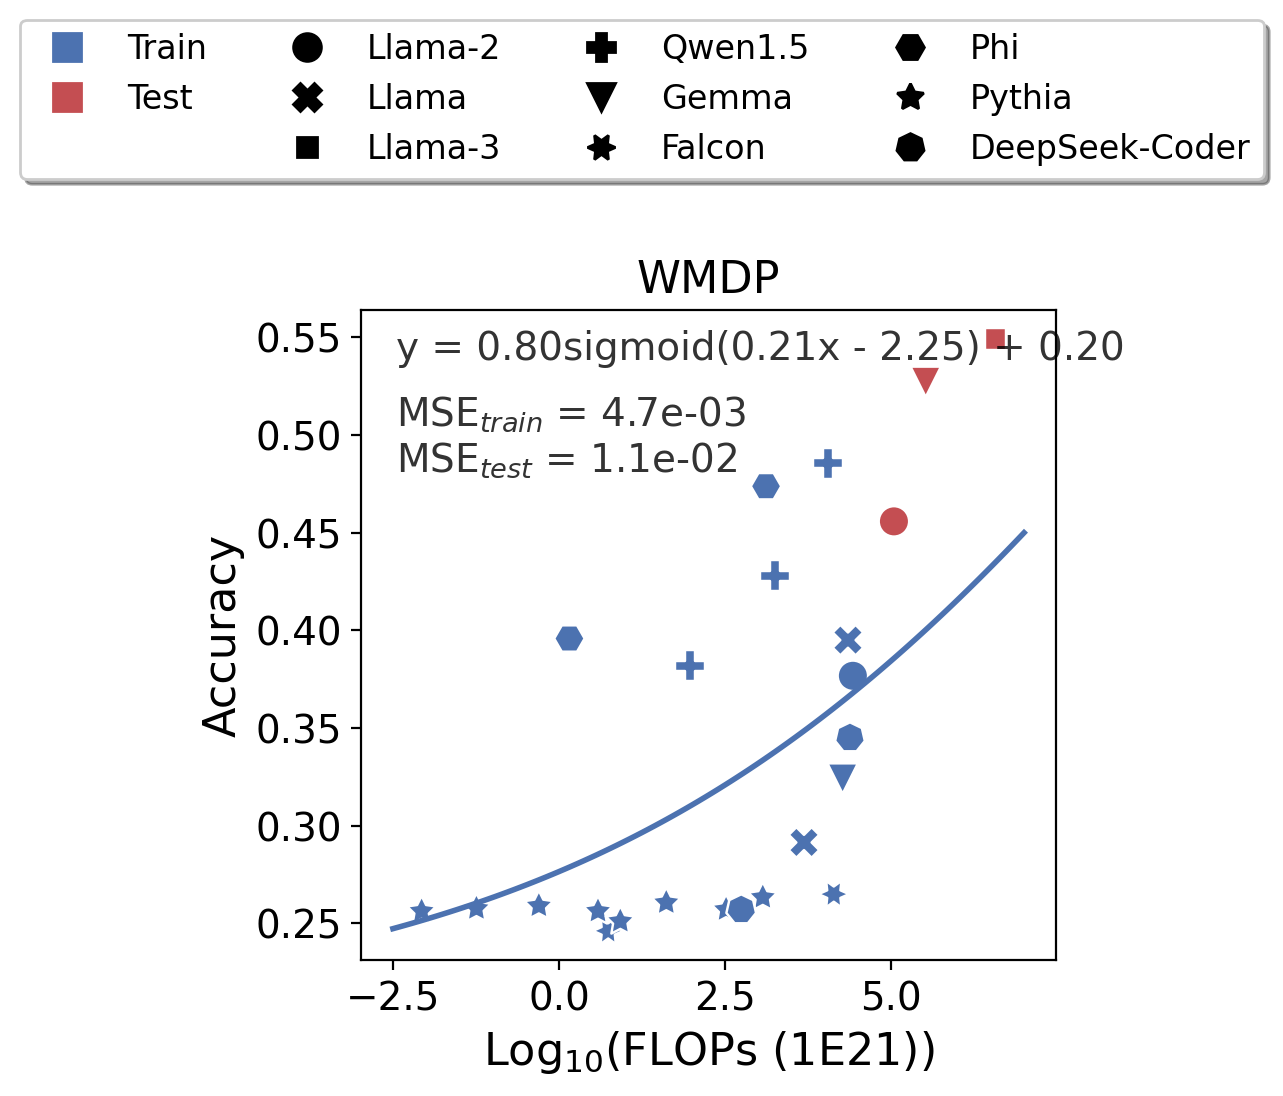

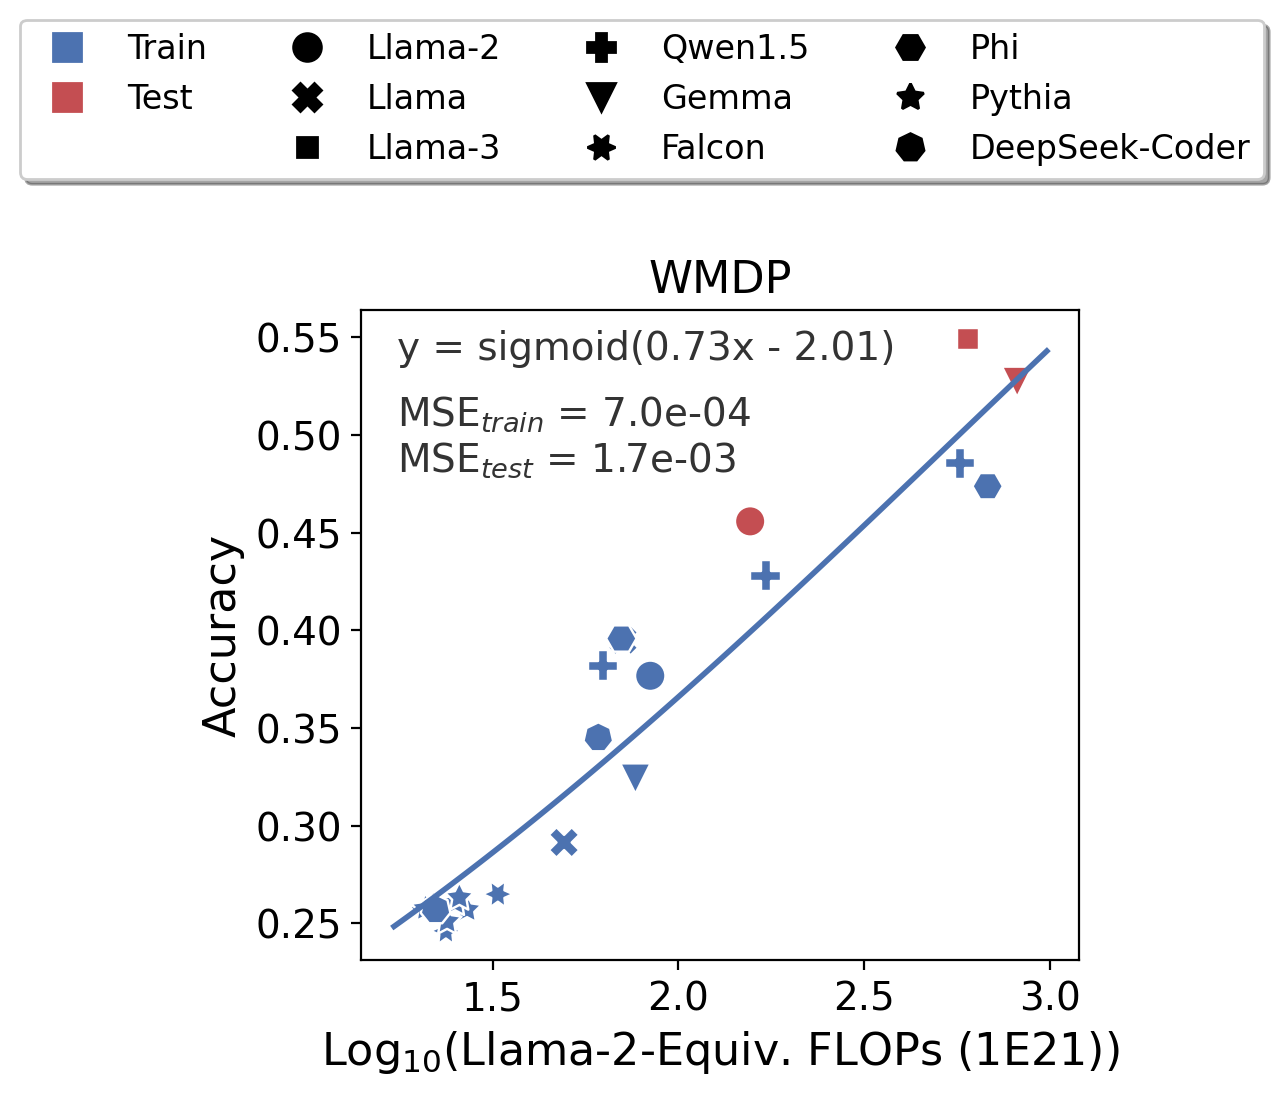

In [6]:
## GSM8K eval metrics with CoT and self-consistency
METRIC_MAP = {
    'wmdp': "WMDP",
}

SCALING_ORIG_METRIC_MAP = {
    **METRIC_MAP
}

SCALING_METRICS = list(METRIC_MAP.keys())

SCALING_METRICS = [
    'wmdp'
]

color_palette = sns.color_palette()

SCALING_COLOR_MAP = {
    'wmdp': color_palette[1]
}


SETUP_SPECIFIC_KWARGS = {}
for e in SCALING_METRICS:
    SETUP_SPECIFIC_KWARGS[e] = {
        "plot_adjust_kwargs": {"title": SCALING_ORIG_METRIC_MAP[e], "ylabel": "Accuracy"},
    }

for x_metrics in PLOT_X_METRICS_LIST:
    fig = plot_multi_scaling_predictions(
        evals, SCALING_METRICS, [x_metrics], 
        SCALING_SETUP_KWARGS, y_metric_specific_kwargs=SETUP_SPECIFIC_KWARGS,
        plot_legend=True, legend_nrow=3, legend_font_size=12, add_dummy_labels=1
    )

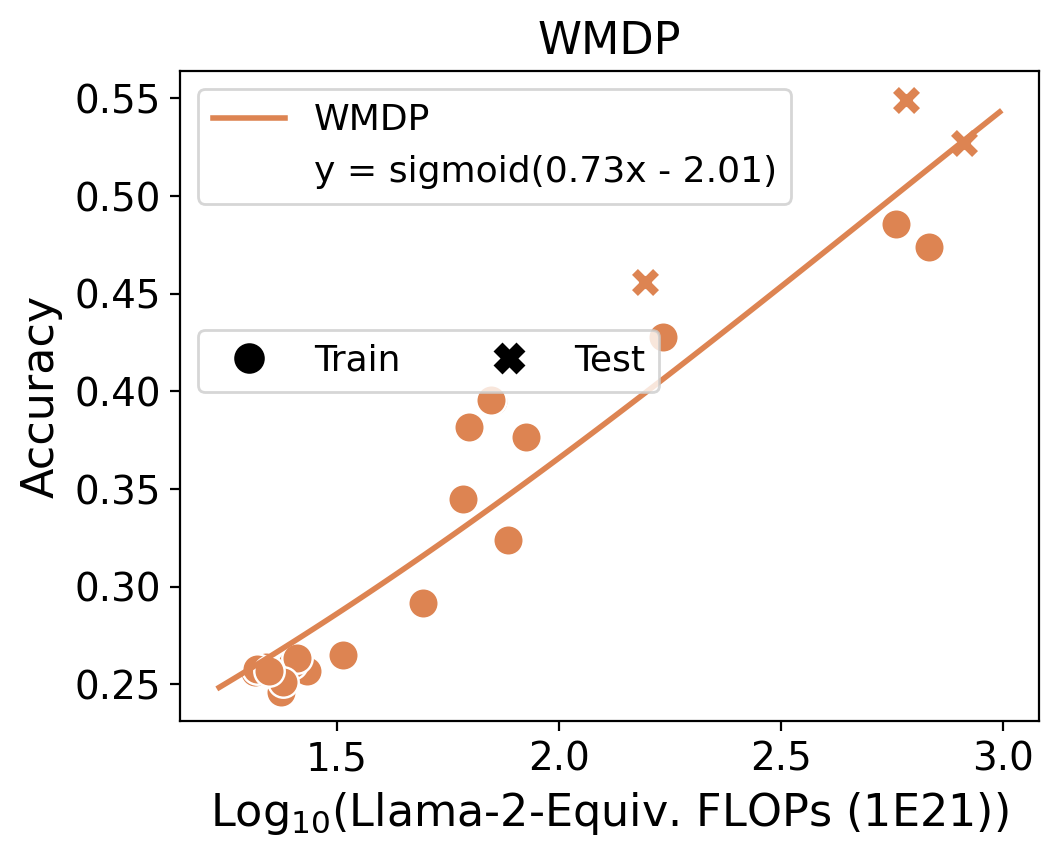

In [7]:
fig = plot_scaling_comparison_multi_metrics(
    evals, SCALING_METRICS, [PC_METRIC_NUM_3], 
    SCALING_SETUP_KWARGS, y_metric_specific_kwargs=SETUP_SPECIFIC_KWARGS,
    ymetric2title_map=SCALING_ORIG_METRIC_MAP, ymetric2color_map=SCALING_COLOR_MAP,
    plot_title="WMDP"
)

/scratch2/jsalle/ObsScaling/utils/plot.py:814: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


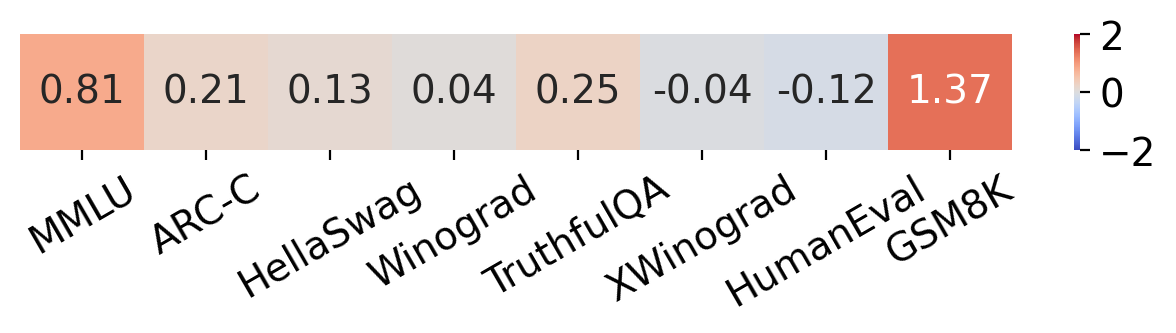

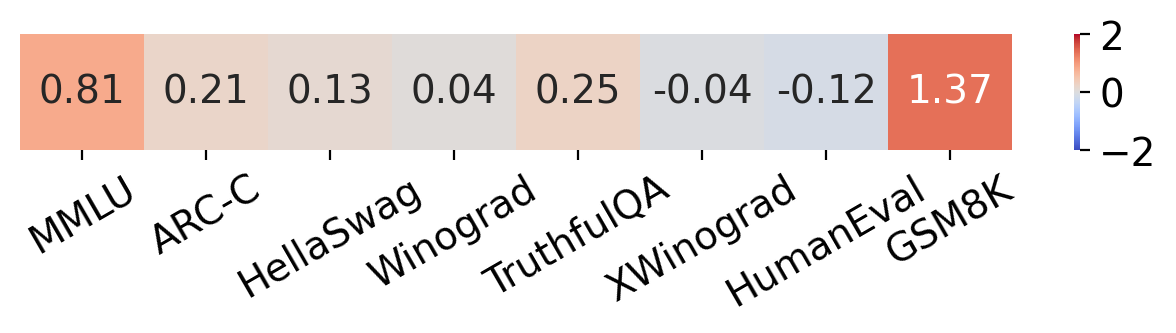

In [8]:
plot_weight_analysis(
    evals, SCALING_METRICS, [PC_METRIC_NUM_3], 
    SCALING_SETUP_KWARGS
)

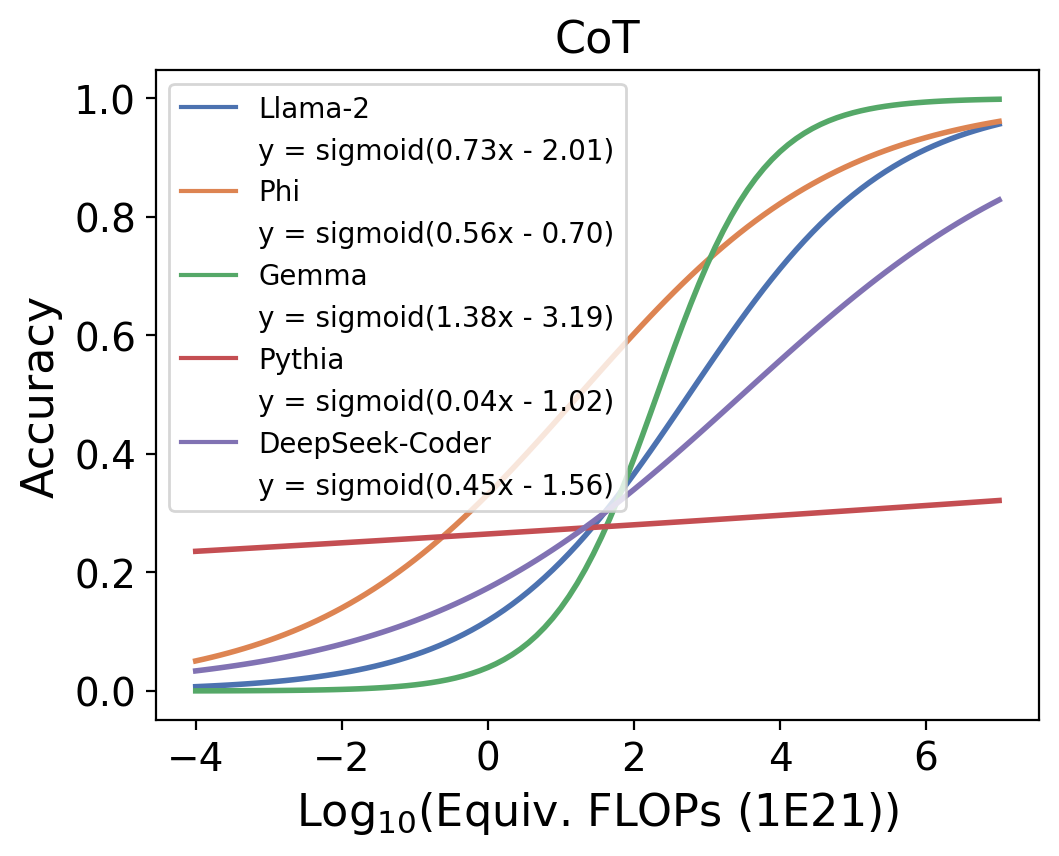

In [9]:
GSM8K_REF_FAMILY_COMPARE = ["Llama-2", "Phi", "Gemma", "Pythia", "DeepSeek-Coder"]
GSM8K_REF_FAMILY_COMPARE_SETUP_KWARGS = SCALING_SETUP_KWARGS.copy()
GSM8K_REF_FAMILY_COMPARE_SETUP_KWARGS["plot_adjust_kwargs"] = {"title": "CoT", "ylabel": "Accuracy", "xlabel": "Log$_{{10}}$(Equiv. FLOPs (1E21))"}

fig = plot_scaling_comparison_multi_families(
    evals, SCALING_METRICS[0], [PC_METRIC_NUM_3], GSM8K_REF_FAMILY_COMPARE, 
    GSM8K_REF_FAMILY_COMPARE_SETUP_KWARGS, title_off=True, plot_xrange=[-4, 7]
)

### WMDP Cyber

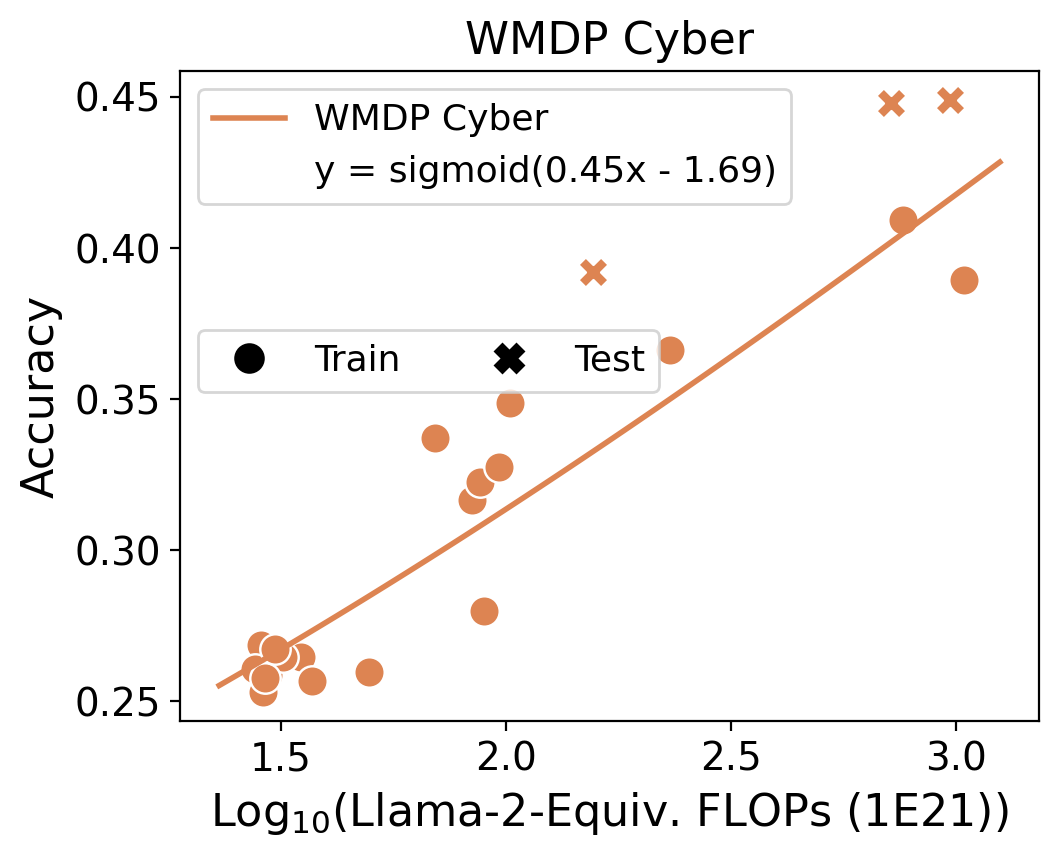

In [16]:
METRIC_MAP = {
    'wmdp_cyber': "WMDP Cyber",
}

SCALING_ORIG_METRIC_MAP = {
    **METRIC_MAP
}

SCALING_METRICS = list(METRIC_MAP.keys())

SCALING_METRICS = [
    'wmdp_cyber'
]

color_palette = sns.color_palette()

SCALING_COLOR_MAP = {
    'wmdp_cyber': color_palette[1]
}


SETUP_SPECIFIC_KWARGS = {}
for e in SCALING_METRICS:
    SETUP_SPECIFIC_KWARGS[e] = {
        "plot_adjust_kwargs": {"title": SCALING_ORIG_METRIC_MAP[e], "ylabel": "Accuracy"},
    }

fig, all_fit_results, metric = plot_scaling_comparison_multi_metrics(
    evals, SCALING_METRICS, [PC_METRIC_NUM_3], 
    SCALING_SETUP_KWARGS, y_metric_specific_kwargs=SETUP_SPECIFIC_KWARGS,
    ymetric2title_map=SCALING_ORIG_METRIC_MAP, ymetric2color_map=SCALING_COLOR_MAP,
    plot_title="WMDP Cyber"
)

/scratch2/jsalle/ObsScaling/utils/plot.py:814: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


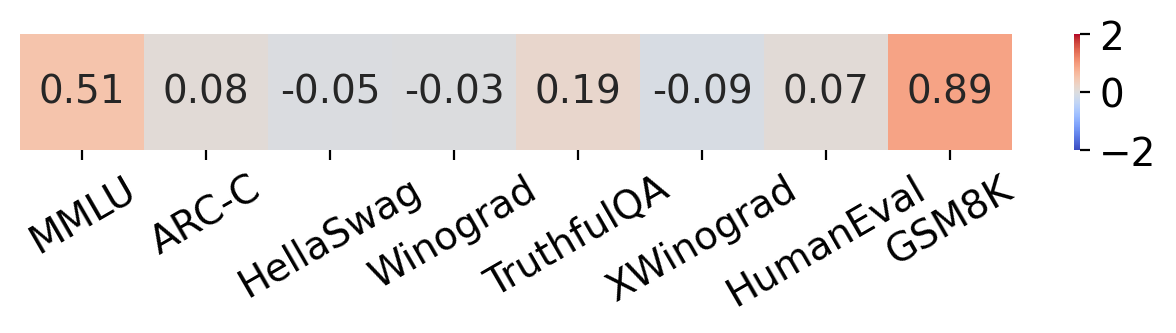

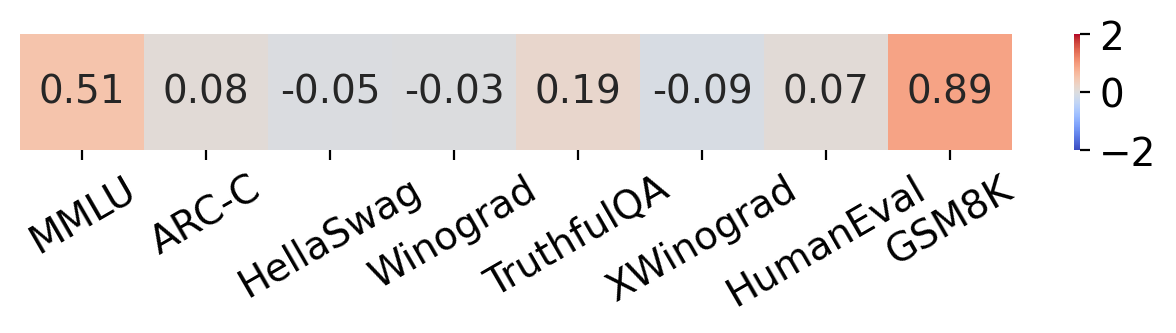

In [17]:
plot_weight_analysis(
    evals, SCALING_METRICS, [PC_METRIC_NUM_3], 
    SCALING_SETUP_KWARGS
)

In [18]:
metric

{'mse_train': 0.0003087910522411873,
 'mse_test': 0.002236386740827594,
 'mae_train': 0.013486571973930878,
 'mae_test': 0.04601991990060378}

### Model-Written Evaluations - Sycophancy

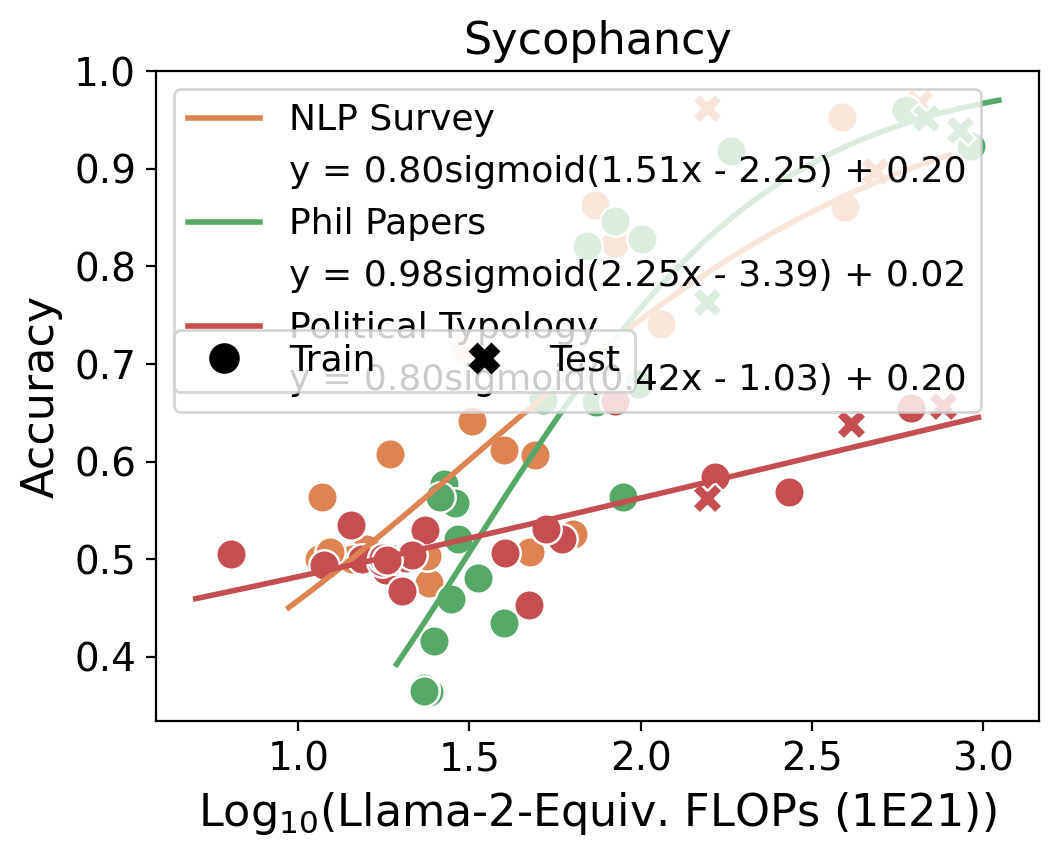

In [12]:
METRIC_MAP = {
    'sycophancy_on_nlp_survey': "NLP Survey",
    'sycophancy_on_philpapers2020': "Phil Papers",
    'sycophancy_on_political_typology_quiz': "Political Typology"
}

SCALING_ORIG_METRIC_MAP = {
    **METRIC_MAP
}

SCALING_METRICS = list(METRIC_MAP.keys())

SCALING_METRICS = [
    'sycophancy_on_nlp_survey',
    'sycophancy_on_philpapers2020',
    'sycophancy_on_political_typology_quiz'
]

color_palette = sns.color_palette()

SCALING_COLOR_MAP = {
    'sycophancy_on_nlp_survey': color_palette[1],
    'sycophancy_on_philpapers2020': color_palette[2],
    'sycophancy_on_political_typology_quiz': color_palette[3]
}



SETUP_SPECIFIC_KWARGS = {}
for e in SCALING_METRICS:
    SETUP_SPECIFIC_KWARGS[e] = {
        "plot_adjust_kwargs": {"title": SCALING_ORIG_METRIC_MAP[e], "ylabel": "Accuracy"},
    }

fig = plot_scaling_comparison_multi_metrics(
    evals, SCALING_METRICS, [PC_METRIC_NUM_3], 
    SCALING_SETUP_KWARGS, y_metric_specific_kwargs=SETUP_SPECIFIC_KWARGS,
    ymetric2title_map=SCALING_ORIG_METRIC_MAP, ymetric2color_map=SCALING_COLOR_MAP,
    plot_title="Sycophancy"
)

/scratch2/jsalle/ObsScaling/utils/plot.py:814: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


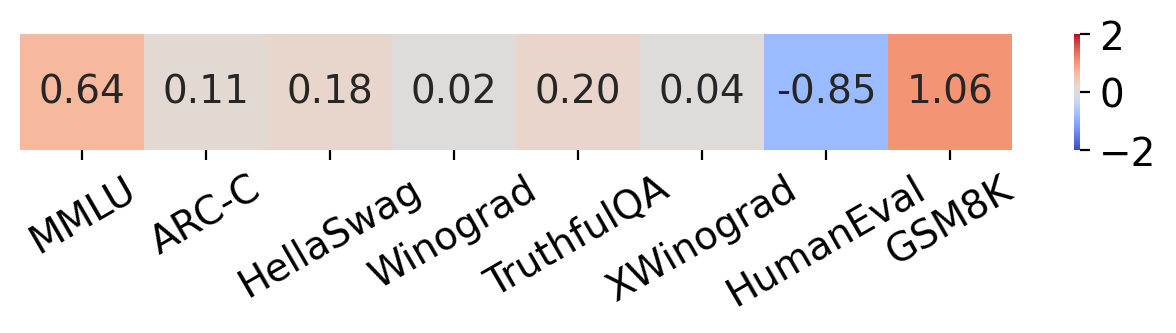

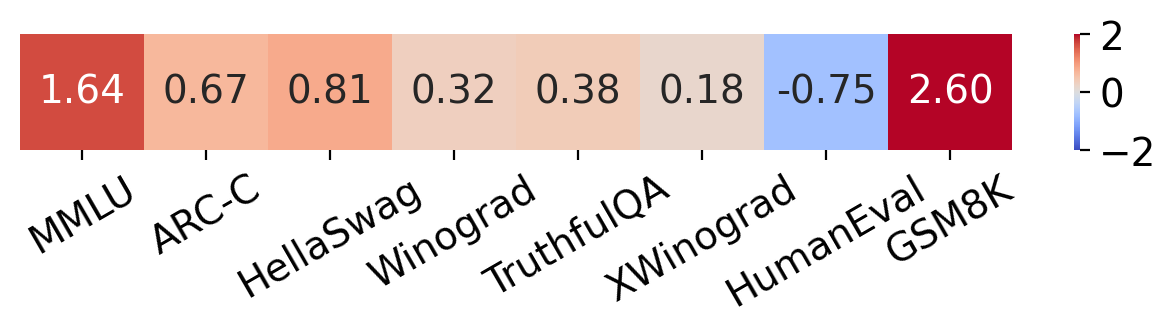

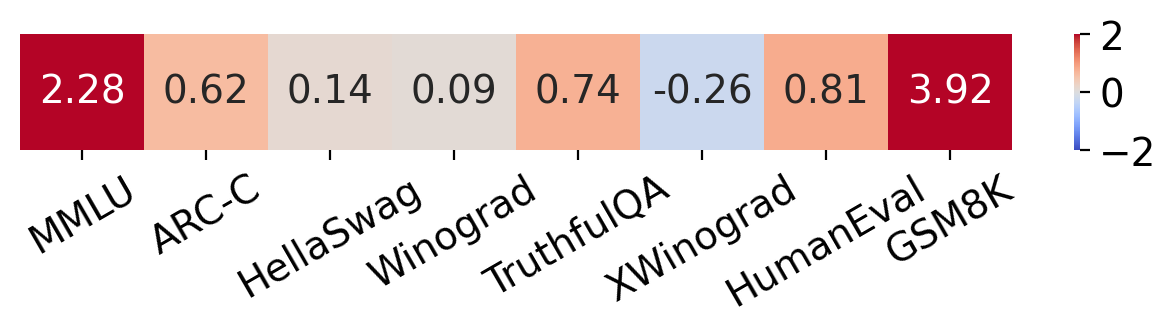

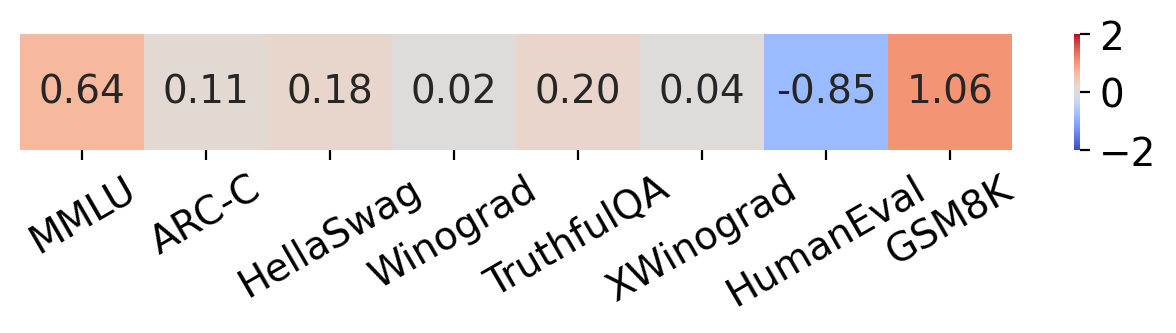

In [13]:
plot_weight_analysis(
    evals, SCALING_METRICS, [PC_METRIC_NUM_3],
    SCALING_SETUP_KWARGS
)

### Advanced AI Risks

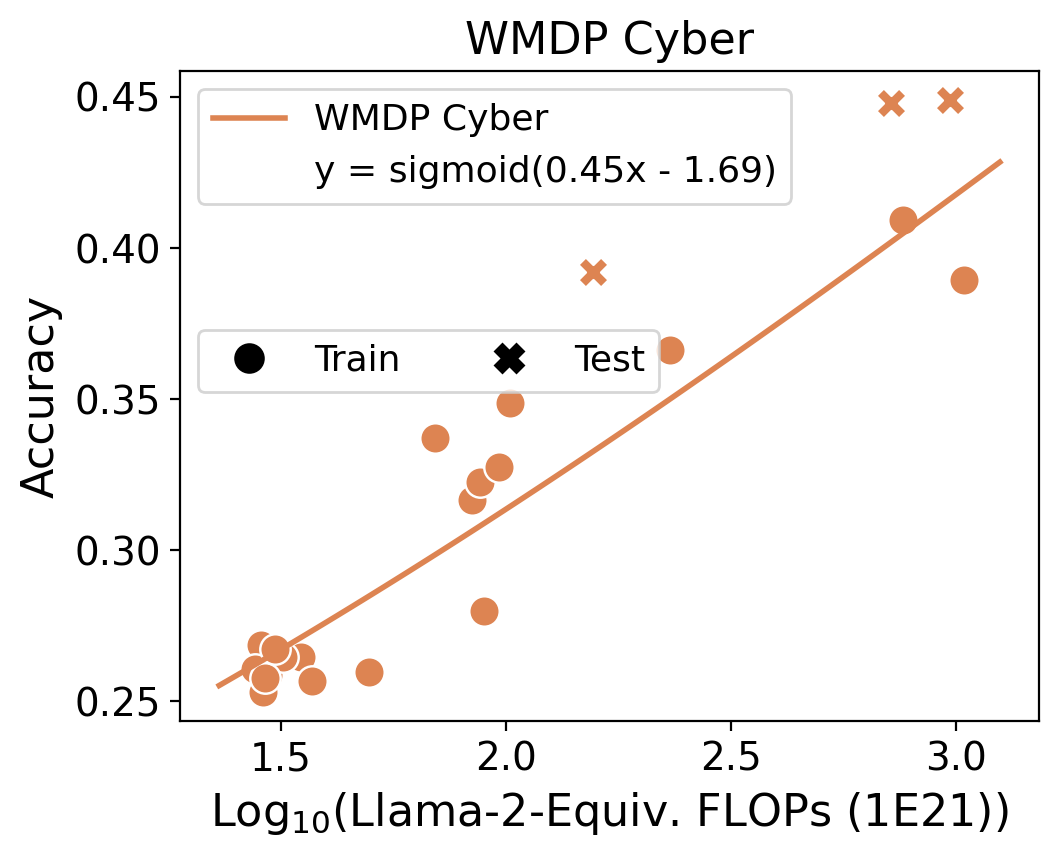

In [14]:
## GSM8K eval metrics with CoT and self-consistency
METRIC_MAP = {
    'wmdp_cyber': "WMDP Cyber",
}

SCALING_ORIG_METRIC_MAP = {
    **METRIC_MAP
}

SCALING_METRICS = list(METRIC_MAP.keys())

SCALING_METRICS = [
    'wmdp_cyber'
]

color_palette = sns.color_palette()

SCALING_COLOR_MAP = {
    'wmdp_cyber': color_palette[1]
}


SETUP_SPECIFIC_KWARGS = {}
for e in SCALING_METRICS:
    SETUP_SPECIFIC_KWARGS[e] = {
        "plot_adjust_kwargs": {"title": SCALING_ORIG_METRIC_MAP[e], "ylabel": "Accuracy"},
    }

fig = plot_scaling_comparison_multi_metrics(
    evals, SCALING_METRICS, [PC_METRIC_NUM_3], 
    SCALING_SETUP_KWARGS, y_metric_specific_kwargs=SETUP_SPECIFIC_KWARGS,
    ymetric2title_map=SCALING_ORIG_METRIC_MAP, ymetric2color_map=SCALING_COLOR_MAP,
    plot_title="WMDP Cyber"
)